# Домашнее задание: основы DL

## Задание 1

Вспомним 1ое зянятие - мы узнали, что в DL мы можем подбирать оптимальные параметры для любой дифференцируемой модели, считая градиенты по обучаемым параметрам.

В этом задании вам предстоит руками сделать backpropagation для совсем простой модели, чтобы понять, что в torch не происходит никакой магии




Пусть:

$x = [1, 1]^T$

$y = [1, -1]^T$

$z = [-1, 2]^T$


$l = sum(max(0, x*y)) + prod(x + z^2)$

где $sum, prod$ - поэлементные сложения и умножения соответственно



В ответ вам нужно указать $\frac{\partial l}{\partial x}$ и $\frac{\partial l}{\partial z}$, а в ноутбуке отобразить, как вы аналитически получили это значение

Для начала: $\frac{\partial l}{\partial x} = \begin{pmatrix}
  \ \frac{d l}{d x_1} \ \frac{d l}{d x_2}
\end{pmatrix}$ и $\frac{\partial l}{\partial z} = \begin{pmatrix}
  \ \frac{d l}{d z_1} \ \frac{d l}{d z_2}
\end{pmatrix}$. Также заметим: $\frac{dl}{d \, sum} = \frac{dl}{d \, prod} = 1$.\
$\frac{d l}{d x_1} = \frac{d \,sum}{dx_1} + \frac{d \, prod}{dx_1} = \frac{d \,max(0, \, x_1 * y_1)}{dx_1} + \frac{d \, max(0, \, x_2 * y_2)}{dx_1} + \frac{d \, (x_1 + z_1 ^ 2)*(x_2 + z_2 ^ 2)}{dx_1} = \frac{d \,max(0, \, x_1)}{dx_1} + \frac{d \, max(0, \, -1)}{dx_1} + \frac{d \, (x_1 + 1)*5}{dx_1} = 1 + 0 + 5=6$

$\frac{d l}{d x_2} = \frac{d \,sum}{dx_2} + \frac{d \, prod}{dx_2} = \frac{d \,max(0, \, x_1 * y_1)}{dx_2} + \frac{d \, max(0, \, x_2 * y_2)}{dx_2} + \frac{d \, (x_1 + z_1 ^ 2)*(x_2 + z_2 ^ 2)}{dx_2} = \frac{d \,max(0, \, 1)}{dx_2} + \frac{d \, max(0, \, -x_2)}{dx_2} + \frac{d \, 2*(x_2 + 4)}{dx_2} = 0 + 0 + 2 = 2$

$\frac{d l}{d z_1} = \frac{d \,sum}{dz_1} + \frac{d \, prod}{dz_1} = \frac{d \,max(0, \, x_1 * y_1)}{dz_1} + \frac{d \, max(0, \, x_2 * y_2)}{dz_1} + \frac{d \, (x_1 + z_1 ^ 2)*(x_2 + z_2 ^ 2)}{dz_1} = \frac{d \, (1 + z_1^2)*5}{dz_1} = 10z_1= -10$
$\frac{d l}{d z_2} = \frac{d \,sum}{dz_2} + \frac{d \, prod}{dz_2} = \frac{d \,max(0, \, x_1 * y_1)}{dz_2} + \frac{d \, max(0, \, x_2 * y_2)}{dz_2} + \frac{d \, (x_1 + z_1 ^ 2)*(x_2 + z_2 ^ 2)}{dz_2} = \frac{d \, 2 * (1 + z_2^2)}{dz_2} = 4z_2= 8$


Для проверки, что вы правильно поняли идею backpropagation, можете подсчитать значение $\frac{\partial l}{\partial y}$, оно должно проходить assert

In [81]:
dl_dy = [1, 0]
assert np.all(dl_dy == [1, 0]), "Пока что неверное, попробуйте еще раз и все получится!"

In [82]:
!pip install -U catalyst

In [83]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

import catalyst
from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

# Задание 2

На занятиях мы часто говорили про линейные модели, что это просто. Давайте реализуем ее сами и попробуем обучать такую модель для задачи классификации (то есть реализуем логистическую регрессию)

На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта.

Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$.

Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$.

Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

## Задание 2.0

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры ([`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).



In [6]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features)) # YOUR CODE HERE

    def forward(self, x):

        res = x @ self.weights # YOUR CODE HERE
        if self.bias:
            res += self.bias_term # YOUR CODE HERE
        return res

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [7]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

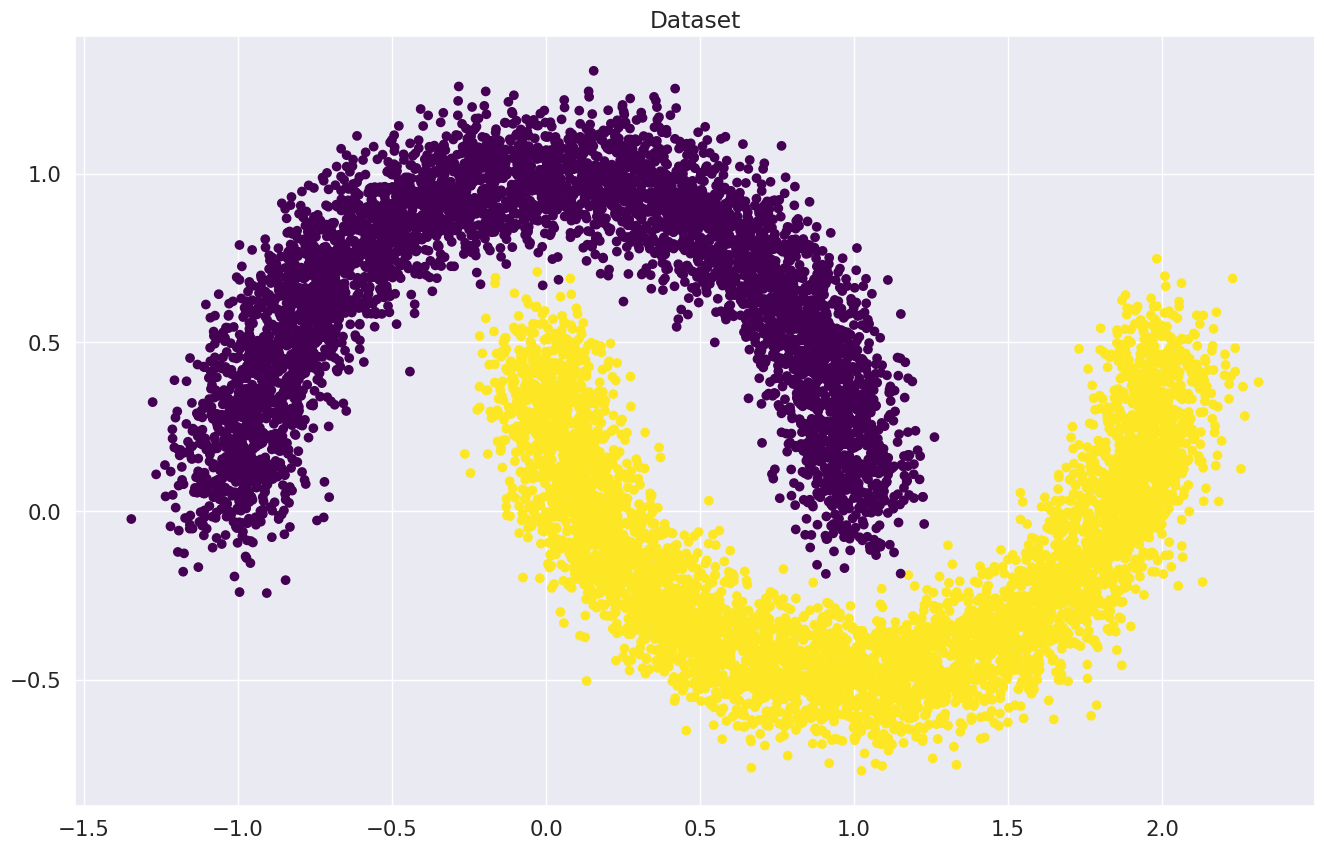

In [8]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [10]:
X_train.shape

(7500, 2)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [11]:
X_train_t =  torch.from_numpy(X_train.astype(np.float32))
y_train_t =  torch.from_numpy(y_train.astype(np.float32))
X_val_t =  torch.from_numpy(X_val.astype(np.float32))
y_val_t =  torch.from_numpy(y_val.astype(np.float32))

Создаем `Dataset` и `DataLoader`.

In [12]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [13]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1, True)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [14]:
X_train_t.shape, y_train_t.shape

(torch.Size([7500, 2]), torch.Size([7500]))

## Задание 2.1 Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3 (необходимо внести в форму)

## Задание 2.2

Теперь обучим эту модель

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [15]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
prev_bias = torch.zeros_like(linear_regression.bias_term)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch).squeeze(dim=-1) # YOUR CODE HERE
        loss = loss_function(outp, y_batch) # YOUR CODE HERE
        loss.backward()
        losses.append(torch.tensor(loss, requires_grad= False)) # YOUR CODE HERE loss value)
        optimizer.step()
        sigm = nn.Sigmoid()
        probabilities =  sigm(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        current_bias = linear_regression.bias_term.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol and (prev_bias - current_bias).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
        prev_bias = current_bias
    if stop_it:
        break

<ipython-input-15-09c3f5688417>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  losses.append(torch.tensor(loss, requires_grad= False)) # YOUR CODE HERE loss value)


Iteration: 0
Batch accuracy: 0.5625
Iteration: 7500
Batch accuracy: 0.765625
Iteration: 15000
Batch accuracy: 0.7890625
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8203125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125
Iteration: 97500
Batch accuracy: 0.828125
Iteration: 105000
Batch accuracy: 0.828125

Iteration: 105054.Convergence. Stopping iterations.


## Задание 2.2

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 105054 необходимо указать в форме

### Визуализируем результаты

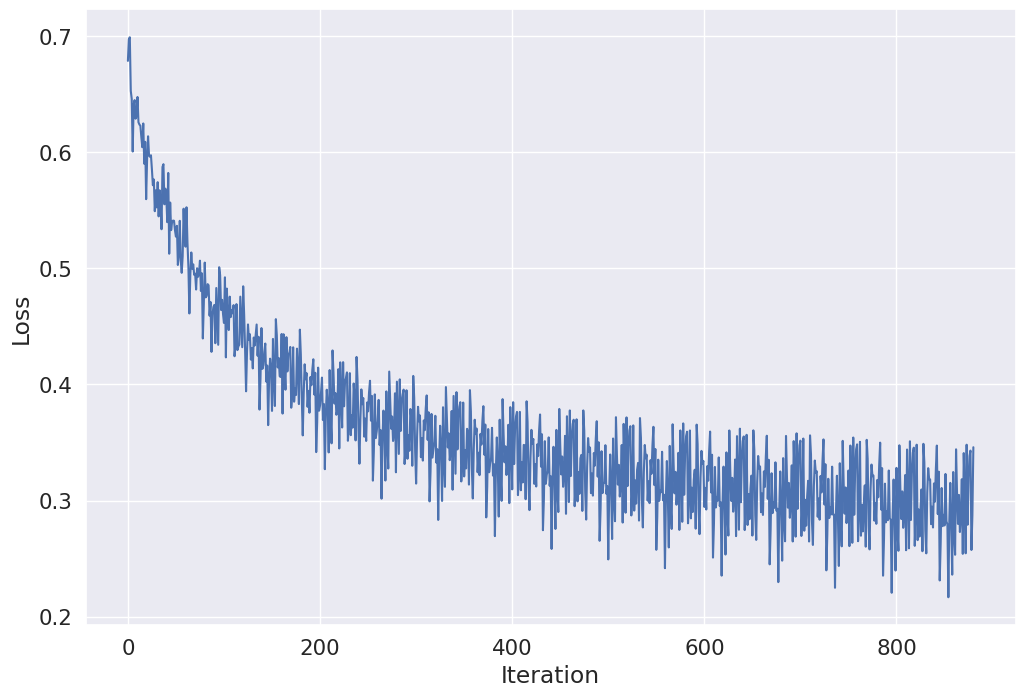

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [17]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [18]:
from sklearn.metrics import accuracy_score

out = predict(val_dataloader, linear_regression)
print(accuracy_score(out, y_val_t))

0.8688


## Задание 2.3

Какое `accuracy` получается после обучения?

**Ответ:** 0.8688 необходимо указать в форме


# Задание 3

Теперь перейдем к датасету MNIST!

На 2ом и 3ем семинаре мы работали с этим датасетом, поэтому ваша задача взять код от туда и исследовать такой интересный вопрос: какая функция активации лучше всего подходит под эту задачу?


Вам необходимо обучить 4 раза модель ниже и сравнить качество для различных функций активаций (или их отсутствия)

In [42]:
import torchvision
from tqdm.notebook import tqdm

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)


train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

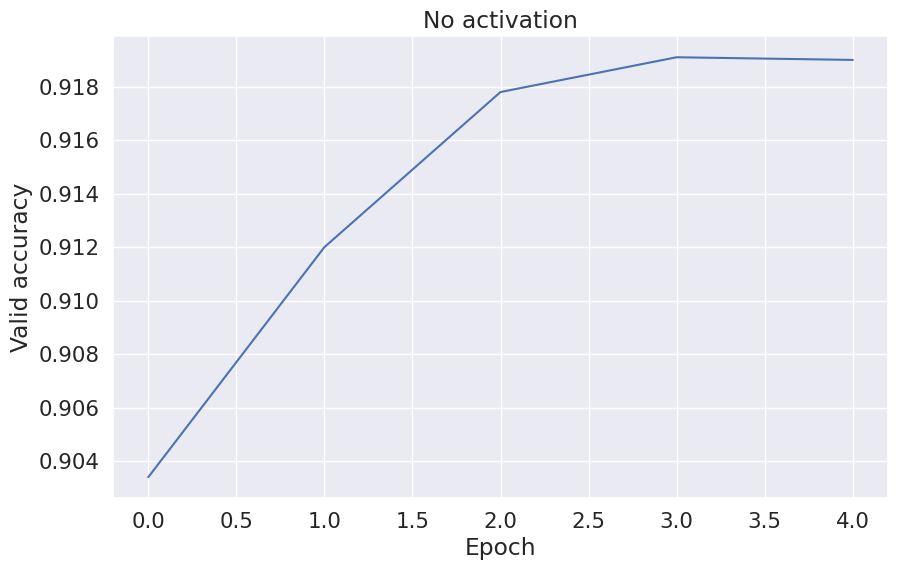

Last accuracy: 0.919


In [48]:
# нужно перебрать: no_activation, ReLU, LeakyReLU, ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.Linear(128, 128),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epoch_accuracies = []
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = model(x_train)  # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)  # считаем лосс
        loss.backward()  # считаем градиенты обратным проходом
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров

    val_accuracy = []
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
            y_pred = model(x_val)  # делаем предсказания
            val_accuracy.extend(
                (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
            )
    epoch_accuracies.append(np.mean(val_accuracy))

plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_accuracies)), epoch_accuracies)
plt.title("No activation")
plt.xlabel("Epoch")
plt.ylabel("Valid accuracy")
plt.show()
print("Last accuracy:", epoch_accuracies[-1])

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

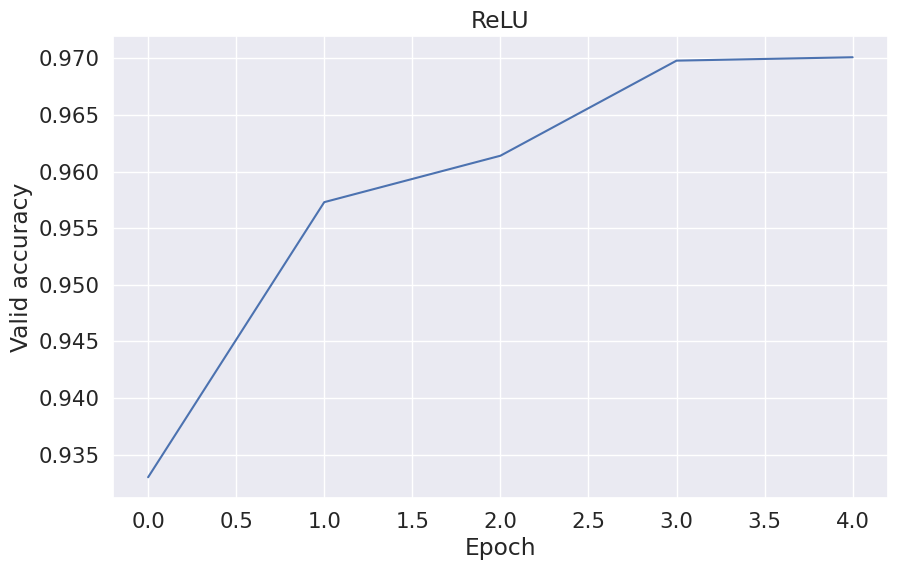

Last accuracy: 0.9701


In [54]:
activation = nn.ReLU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.035)

epoch_accuracies = []
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = model(x_train)  # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)  # считаем лосс
        loss.backward()  # считаем градиенты обратным проходом
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров

    val_accuracy = []
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
            y_pred = model(x_val)  # делаем предсказания
            val_accuracy.extend(
                (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
            )
    epoch_accuracies.append(np.mean(val_accuracy))

plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_accuracies)), epoch_accuracies)
plt.title("ReLU")
plt.xlabel("Epoch")
plt.ylabel("Valid accuracy")
plt.show()
print("Last accuracy:", epoch_accuracies[-1])

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

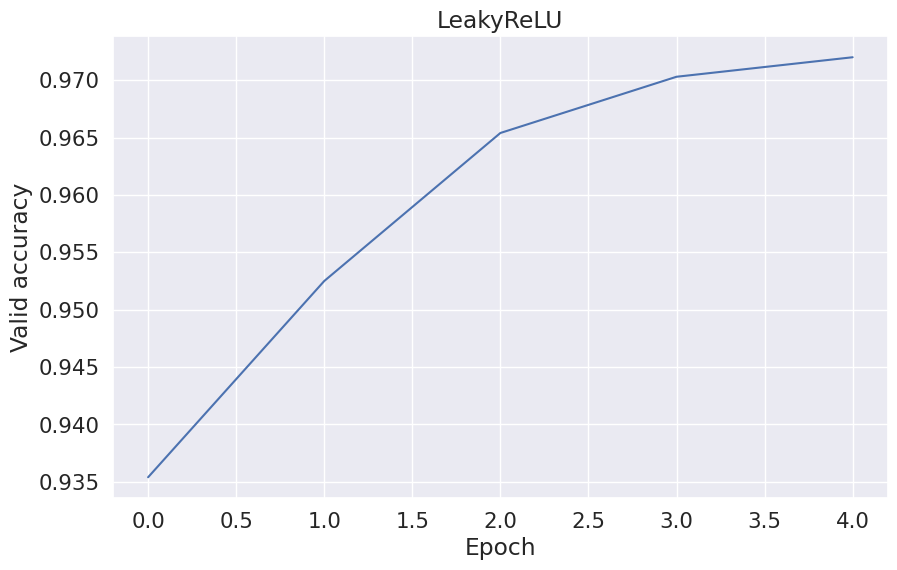

Last accuracy: 0.972


In [55]:
activation = nn.LeakyReLU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.035)

epoch_accuracies = []
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = model(x_train)  # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)  # считаем лосс
        loss.backward()  # считаем градиенты обратным проходом
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров

    val_accuracy = []
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
            y_pred = model(x_val)  # делаем предсказания
            val_accuracy.extend(
                (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
            )
    epoch_accuracies.append(np.mean(val_accuracy))

plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_accuracies)), epoch_accuracies)
plt.title("LeakyReLU")
plt.xlabel("Epoch")
plt.ylabel("Valid accuracy")
plt.show()
print("Last accuracy:", epoch_accuracies[-1])

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

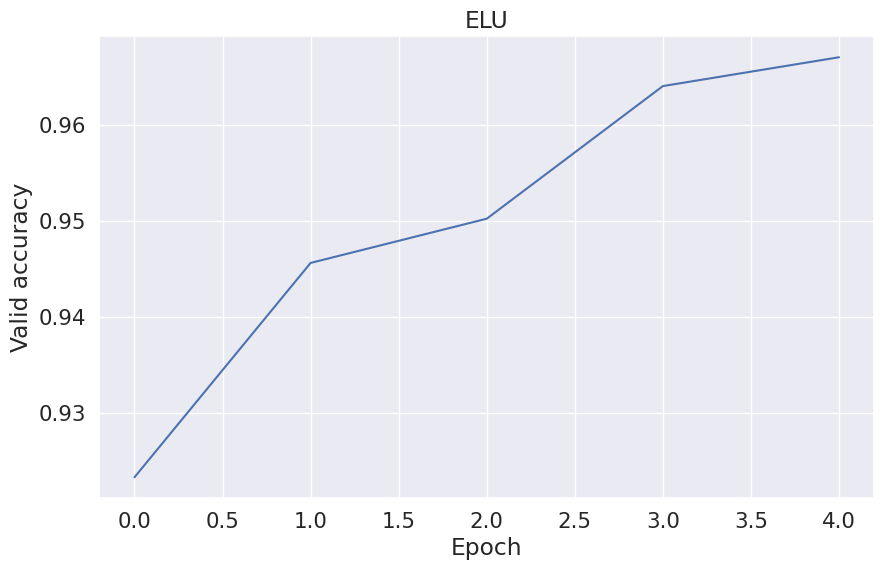

Last accuracy: 0.967


In [56]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.035)

epoch_accuracies = []
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = model(x_train)  # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)  # считаем лосс
        loss.backward()  # считаем градиенты обратным проходом
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров

    val_accuracy = []
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
            y_pred = model(x_val)  # делаем предсказания
            val_accuracy.extend(
                (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
            )
    epoch_accuracies.append(np.mean(val_accuracy))

plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_accuracies)), epoch_accuracies)
plt.title("ELU")
plt.xlabel("Epoch")
plt.ylabel("Valid accuracy")
plt.show()
print("Last accuracy:", epoch_accuracies[-1])

Необходимо построить график: valid accuracy от номера эпохи (максимум 10 эпох) для разных функций активации и выбрать лучшую из них

**Вопрос 3** Какая из активаций показала наивысший `accuracy`?

**Ответ:**LeakyReLU необходимо указать в форме

# Задание 4

Теперь обучим архитектуру, которая использует операции nn.Conv2d. На семинарах мы наблюдали, что можем сильно увеличить качество решения.

Давайте посмотрим на архитектуру, предложенную еще в 1998 году - [LeNet](https://en.wikipedia.org/wiki/LeNet)!

In [75]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # YOUR CODE HERE
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1) # YOUR CODE HERE
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": val_dataloader}


Необходимо обучить модель и сравнить дают ли сверточные слои прирост к качеству? Для этого ответить на вопрос

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

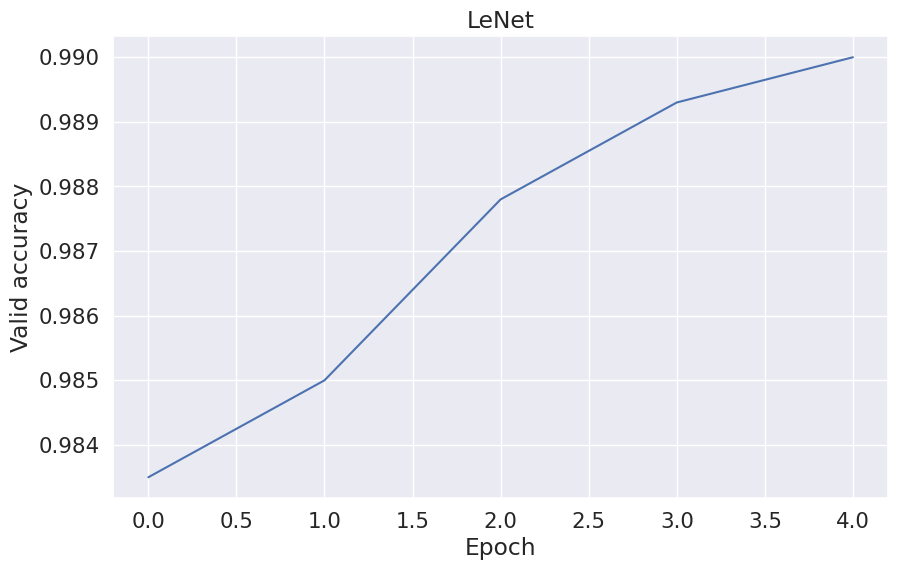

Last accuracy: 0.99


In [78]:
epoch_accuracies = []
for epoch in range(5):
    for x_train, y_train in tqdm(loaders['train']):  # берем батч из трейн лоадера
        y_pred = model(x_train)  # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)  # считаем лосс
        loss.backward()  # считаем градиенты обратным проходом
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров

    val_accuracy = []
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(loaders['valid']):  # берем батч из валидационного лоадера
            y_pred = model(x_val)  # делаем предсказания
            val_accuracy.extend(
                (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
            )
    epoch_accuracies.append(np.mean(val_accuracy))

plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_accuracies)), epoch_accuracies)
plt.title("LeNet")
plt.xlabel("Epoch")
plt.ylabel("Valid accuracy")
plt.show()
print("Last accuracy:", epoch_accuracies[-1])

## Задание 4
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99необходимо указать в форме